In [1]:
from sklearn.datasets import make_blobs
import random
import numpy as np
from sklearn import model_selection
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
from matplotlib.colors import ListedColormap

In [3]:
X, y = load_iris(return_X_y=True)
X = X[:, :2]

In [4]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=1)

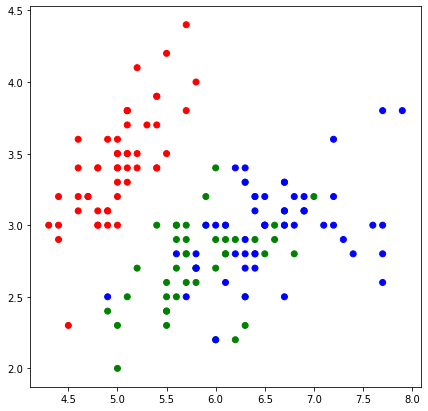

In [5]:
cmap = ListedColormap(['red', 'green', 'blue'])
plt.figure(figsize=(7, 7))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap)

In [6]:
def e_metrics(x1, x2):
    
    distance = 0
    for i in range(len(x1)):
        distance += np.square(x1[i] - x2[i])
    
    return np.sqrt(distance)

In [7]:
def knn(x_train, y_train, x_test, k):
    
    answers = []
    for x in x_test:
        test_distances = []
            
        for i in range(len(x_train)):
            
            # расчёт расстояния от классифицируемого объекта до
            # объекта обучающей выборки
            distance = e_metrics(x, x_train[i])
            
            # Записываем в список значение расстояния и ответа на объекте обучающей выборки
            test_distances.append((distance, y_train[i]))
        
        # создаём словарь со всеми возможными классами
        classes = {class_item: 0 for class_item in set(y_train)}
        
        # Сортируем список и среди первых k-элементов подсчитаем частоту появления разных классов
        for d in sorted(test_distances)[0:k]:
            classes[d[1]] += 1
            
        # Записываем в список ответов наиболее часто встречающийся класс
        answers.append(sorted(classes, key=classes.get)[-1])
    return answers

In [8]:
def accuracy(pred, y):
    return (sum(pred == y) / len(y))

In [44]:
k = 5

y_pred = knn(X_train, y_train, X_test, k)

print(f'Точность алгоритма при k = {k}: {accuracy(y_pred, y_test):.3f}')

Точность алгоритма при k = 5: 0.867


In [10]:
def get_graph(X_train, y_train, k):
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA','#00AAFF'])

    h = .02

    # Расчёт пределов графика
    x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
    y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # Получим предсказания для всех точек
    Z = knn(X_train, y_train, np.c_[xx.ravel(), yy.ravel()], k)

    # Построим график
    Z = np.array(Z).reshape(xx.shape)
    plt.figure(figsize=(7,7))
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

    # Добавим на график обучающую выборку
    plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cmap)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title(f"Трехклассовая kNN классификация при k = {k}")
    plt.show()

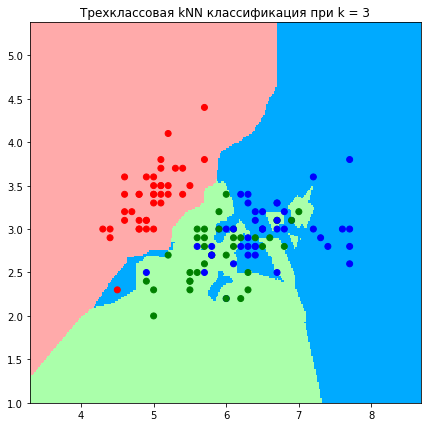

Wall time: 1min 1s


In [13]:
%%time
get_graph(X_train, y_train, k)

1. К алгоритму kNN, реализованному на уроке, реализуйте добавление весов соседей по любому из показанных на уроке принципов.

In [35]:
def knn_weighted(x_train, y_train, x_test, k):
    
    answers = []
    for x in x_test:
        test_distances = []
            
        for i in range(len(x_train)):
            distance = e_metrics(x, x_train[i])
            test_distances.append((distance, y_train[i]))
        
        classes = {class_item: 0 for class_item in set(y_train)}
       
    # добавляем к счетчику классов не количество соседей по классам, а их вес
        for d in sorted(test_distances)[0:k]:
            classes[d[1]] += 0.5 ** d[0]           
            
        answers.append(sorted(classes, key=classes.get)[-1])
    return answers

In [43]:
k = 5

y_pred_w = knn_weighted(X_train, y_train, X_test, k)

print(f'Точность алгоритма при k = {k}: {accuracy(y_pred_w, y_test):.3f}')

Точность алгоритма при k = 5: 0.867


2. Напишите функцию по подсчёту метрики качества кластеризации как среднее квадратичное внутрикластерное расстояние и постройте график её зависимости от k (взять от 1 до 10) для выборки данных из этого урока.

In [101]:
X, y = make_blobs(n_samples=100, random_state=1)

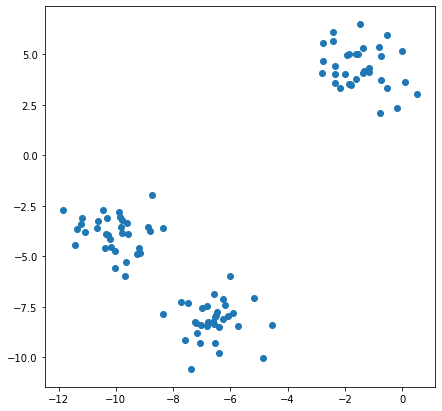

In [39]:
plt.figure(figsize=(7,7))
plt.scatter(X[:, 0], X[:, 1])
plt.show()

In [45]:
def kmeans(data, k, max_iterations, min_distance):    
    # инициализируем центроиды как первые k элементов датасета
    centroids = [data[i] for i in range(k)]
    
    for _ in range(max_iterations):
        # Создадим словарь для классификации
        classes = {i: [] for i in range(k)}
        
        # классифицируем объекты по центроидам
        for x in data:
            # определим расстояния от объекта до каждого центроида
            distances = [e_metrics(x, centroid) for centroid in centroids]
            # отнесём объект к кластеру, до центроида которого наименьшее расстояние
            classification = distances.index(min(distances))
            classes[classification].append(x)
        
        # сохраним предыдущие центроиды в отдельный список для последующего сравнения с новыми
        old_centroids = centroids.copy()
        
        # пересчитаем центроиды как среднее по кластерам
        for classification in classes:
            centroids[classification] = np.average(classes[classification], axis=0)
            
        # сравним величину смещения центроидов с минимальной
        optimal = True
        for centroid in range(len(centroids)):
            if np.sum(abs((centroids[centroid] - old_centroids[centroid]) / old_centroids * 100)) > min_distance:
                optimal = False
                
        # если все смещения меньше минимального, останавливаем алгоритм  
        if optimal:
            break
    
    return old_centroids, classes

In [50]:
max_iterations = 10
min_distance = 1e-4
k = 3
centroids, clusters = kmeans(X, k, max_iterations, min_distance)

In [ ]:
centr = np.array([1, 2])
clast = np.array([[2, 3], [3, 4], [4, 5]])

In [112]:
def my_metrics(x1, x2):
    
    distance = 0
    for i in range(len(x1)):
        distance += np.square(x1[i] - x2[i])
    
    return distance

def elbow (data):
    dots = []
    ks = range(1, 11)
    max_iterations = 10
    min_distance = 1e-4
    for k in ks:
        centroids, clusters = kmeans(X, k, max_iterations, min_distance)
        summa = 0
        for i in range(len(centroids)):
            summa += (sum([my_metrics(centroids[i], cluster) for cluster in clusters[i]]))/len(clusters[i])                
        dots.append(summa)
    return dots, ks

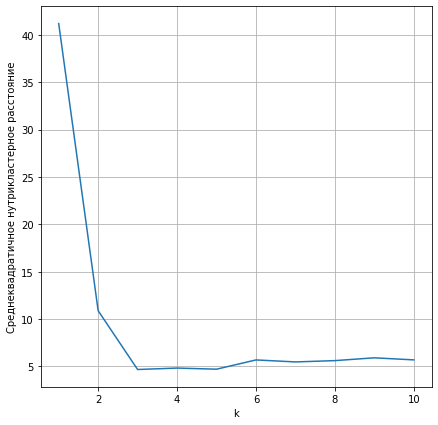

In [114]:
dots, ks = elbow(X)
plt.figure(figsize=(7,7))
plt.grid()
plt.ylabel('Среднеквадратичное нутрикластерное расстояние')
plt.xlabel('k')
plt.plot(ks, dots)
plt.show()